# Deep Leakage from Gradients

This notebook shows an example for an attack as described in "Deep Leakage from Gradients".

Paper URL: https://papers.nips.cc/paper/2019/hash/60a6c4002cc7b29142def8871531281a-Abstract.html

#### Abstract
Passing gradient is a widely used scheme in modern multi-node learning system (e.g, distributed training, collaborative learning). In a long time, people used to believe that gradients are safe to share: i.e, the training set will not be leaked by gradient sharing. However, in this paper, we show that we can obtain the private training set from the publicly shared gradients. The leaking only takes few gradient steps to process and can obtain the original training set instead of look-alike alternatives. We name this leakage as \textit{deep leakage from gradient} and practically validate the effectiveness of our algorithm on both computer vision and natural language processing tasks. We empirically show that our attack is much stronger than previous approaches and thereby and raise people's awareness to rethink the gradients' safety. We also discuss some possible strategies to defend this deep leakage.

### Startup

In [2]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching

import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

/Users/harishdamodar/anaconda3/envs/breaching/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/harishdamodar/anaconda3/envs/breaching/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <9E1A0B70-7AFB-30E2-B230-74CF804853DE> /Users/harishdamodar/anaconda3/envs/breaching/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <6384E44A-E10D-30C9-994F-E34B0519E5B3> /Users/harishdamodar/anaconda3/envs/breaching/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [3]:
cfg = breaching.get_config(overrides=["case=1_single_image_small", "attack=deepleakage"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

/Users/harishdamodar/anaconda3/envs/breaching/lib/python3.9/site-packages/breaching/__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


Investigating use case single_image_small with server type honest_but_curious.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [4]:
cfg.case.data.partition="unique-class"
cfg.case.user.user_idx = 1

cfg.case.user.provide_labels=False # This attack can reconstruct label information via optimization.

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [5]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture ConvNet loaded with 2,904,970 parameters and 3,208 buffers.
Overall this is a data ratio of     946:1 for target shape [1, 3, 32, 32] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 1
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ConvNet
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationJointAttacker) with settings:
    Hyperparameter Template: deep-leakage

    Objective: Euclidean loss with scale=1.0 and task reg=0.0
    Regularizers: 
    Augmentations: 

    Optimization Setup:
        opti

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 1 in model mode: eval.


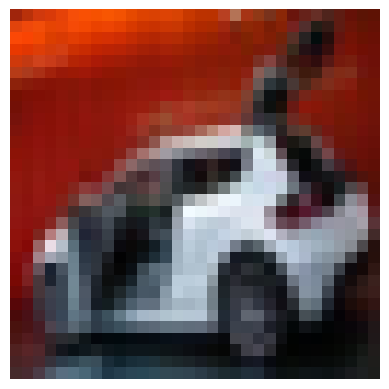

In [7]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [8]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 0.9218 |  Task loss: 2.2971 | T: 1.04s |  Label Entropy: 0.0000.
| It: 101 | Rec. loss: 0.0023 |  Task loss: 2.2971 | T: 212.78s |  Label Entropy: 0.0050.
| It: 201 | Rec. loss: 0.0026 |  Task loss: 2.2971 | T: 394.30s |  Label Entropy: 0.0077.
| It: 301 | Rec. loss: 0.0029 |  Task loss: 2.2971 | T: 299.21s |  Label Entropy: 0.0054.
| It: 401 | Rec. loss: 0.0038 |  Task loss: 2.2971 | T: 287.90s |  Label Entropy: 0.0075.
| It: 501 | Rec. loss: 0.0024 |  Task loss: 2.2971 | T: 253.34s |  Label Entropy: 0.0061.
| It: 601 | Rec. loss: 0.0032 |  Task loss: 2.2970 | T: 224.46s |  Label Entropy: 0.0045.


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [ ]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

Files already downloaded and verified
METRICS: | MSE: 0.0046 | PSNR: 23.41 | FMSE: 2.7202e-09 | LPIPS: 0.00|
 R-PSNR: 23.41 | IIP-pixel: 100.00% | SSIM: 0.8755 | max R-PSNR: 23.41 | max SSIM: 0.8755 | Label Acc: 0.00%


And finally, we also plot the reconstructed data:

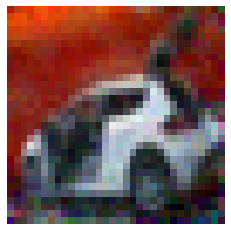

In [ ]:
user.plot(reconstructed_user_data)

### Notes
* The model from the original paper can be retrieved with `case.model=lenet_zhu`
* This attack often works, but for more challenging models can get stuck in bad local minima. Restarting the attack several, (e.g. by setting `attack.restarts.num_trials=16` can help here.